<a href="https://colab.research.google.com/github/Anil-matcha/ESPCN/blob/main/ESPCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip -d ./Training
!rm DIV2K_train_HR.zip

In [ ]:
upscale_factor = 3
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

inputs = keras.Input(shape=(None, None, 1))
conv1 = layers.Conv2D(64, 5, activation="tanh", padding="same")(inputs)
conv2 = layers.Conv2D(32, 3, activation="tanh", padding="same")(conv1)
conv3 = layers.Conv2D((upscale_factor*upscale_factor), 3, activation="sigmoid", padding="same")(conv2)
outputs = tf.nn.depth_to_space(conv3, upscale_factor, data_format='NHWC')
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
def gen_dataset(filenames, scale):
    # The model trains on 17x17 patches
    crop_size_lr = 17
    crop_size_hr = 17 * scale

    for p in filenames:
        image_decoded = cv2.imread("Training/DIV2K_train_HR/"+p.decode(), 3).astype(np.float32) / 255.0
        imgYCC = cv2.cvtColor(image_decoded, cv2.COLOR_BGR2YCrCb)
        cropped = imgYCC[0:(imgYCC.shape[0] - (imgYCC.shape[0] % scale)),
                  0:(imgYCC.shape[1] - (imgYCC.shape[1] % scale)), :]
        lr = cv2.resize(cropped, (int(cropped.shape[1] / scale), int(cropped.shape[0] / scale)),
                        interpolation=cv2.INTER_CUBIC)

        hr_y = imgYCC[:, :, 0]
        lr_y = lr[:, :, 0]

        numx = int(lr.shape[0] / crop_size_lr)
        numy = int(lr.shape[1] / crop_size_lr)
        for i in range(0, numx):
            startx = i * crop_size_lr
            endx = (i * crop_size_lr) + crop_size_lr
            startx_hr = i * crop_size_hr
            endx_hr = (i * crop_size_hr) + crop_size_hr
            for j in range(0, numy):
                starty = j * crop_size_lr
                endy = (j * crop_size_lr) + crop_size_lr
                starty_hr = j * crop_size_hr
                endy_hr = (j * crop_size_hr) + crop_size_hr

                crop_lr = lr_y[startx:endx, starty:endy]
                crop_hr = hr_y[startx_hr:endx_hr, starty_hr:endy_hr]

                hr = crop_hr.reshape((crop_size_hr, crop_size_hr, 1))
                lr = crop_lr.reshape((crop_size_lr, crop_size_lr, 1))
                yield lr, hr

In [ ]:
import os
filenames = os.listdir("Training/DIV2K_train_HR/")
ds = tf.data.Dataset.from_generator(
        gen_dataset, (tf.float32, tf.float32), (tf.TensorShape([None, None, 1]), tf.TensorShape([None, None, 1])),
        args=[filenames, upscale_factor]).batch(64).shuffle(buffer_size=10000)

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='mse', 
              metrics=PSNR)

In [ ]:
model.fit(ds, epochs=100, verbose=2)

In [ ]:
import math
def PSNR(orig, reconstr):
    mse = np.mean((orig.astype(float) - reconstr.astype(float)) ** 2)
    if mse != 0:
        max_pixel = 255.0
        return 20 * math.log10(max_pixel / math.sqrt(mse))
    else:
        return 1

fullimg = cv2.imread("test.png", 3)
width = fullimg.shape[0]
height = fullimg.shape[1]
cropped = fullimg[0:(width - (width % upscale_factor)), 0:(height - (height % upscale_factor)), :]
img = cv2.resize(cropped, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation=cv2.INTER_CUBIC)
floatimg = img.astype(np.float32) / 255.0
imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
imgY = imgYCbCr[:, :, 0]
LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
Y = model.predict([LR_input_])[0]
Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)
HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
HR_image = (HR_image).astype(np.uint8)
bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
print("PSNR of ESPCN generated image: ", PSNR(cropped, HR_image))
print("PSNR of bicubic interpolated image: ", PSNR(cropped, bicubic_image))

PSNR of ESPCN generated image:  29.34897242930792
PSNR of bicubic interpolated image:  28.804309468772477


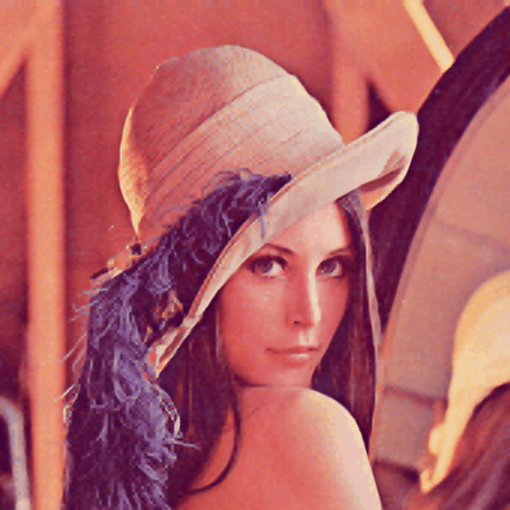

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(HR_image)

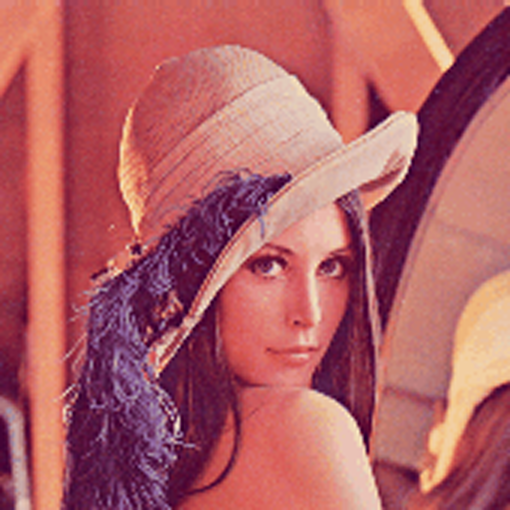

In [ ]:
cv2_imshow(bicubic_image)